<div style="float: right;">
    <img src="https://www.osgeo.org/wp-content/uploads/rasdaman_logo-1-370x206.png" width="250" style="display: inline-block;"/>
</div>

# A Short Story about OGC WCS / WCPS

This notebook gives a quick overview of python access to datacubes via the OGC WCS and WCPS standards. The requests demonstrated access CODE-DE Datacube service enabled by the datacube reference implementation, rasdaman. Access end point uniformly is https://mundi.rasdaman.com/rasdaman/ows.

## Data Overview

- **Sentinel 2**
    - *CRS*: varying for each datacube depending on the UTM zone it covers
    - *Datacube names*: 
        - **Level-2A**: `S2_L2A_${utmCrsCode}_${band}_${resolution}`
          - `${utmCrsCode}` - the EPSG code for datacube CRS: 32628 - 32637 (N)
          - `${band}` - B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12, TCI, SCL, CLDPRB, SNWPRB, WVP and AOT
          - `${resolution}` - 10m, 20m or 60m
          - *Example*: `S2_L2A_32626_AOT_20m`
        - **Level-1C**: `S2_L1C_${utmCrsCode}_${band}_${resolution}`
          - `${utmCrsCode}` - the EPSG code for datacube CRS: 32601 - 32660 (N)
          - `${band}` - B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B10, B11, B12, TCI and PVI
          - `${resolution}` - 10m, 20m, 60m or 320m (band PVI)
          

## Web Coverage Service (WCS)

WCS is a standarized data access protocol for datacubes (*coverages* in OGC terminology). For the purpose of this notebook we use GET/KVP which nicely maps to URLs; further possible protocols include POST/XML, SOAP, and in future OAPI-Coverages.

WCS supports three core requests, all of which uniformly start with https://mundi.rasdaman.com/rasdaman/ows?service=WCS&version=2.0.1&request= as you can see:

* **GetCapabilities** returns a description (in XML) of the service capabilities together with an overview of all coverages available on the server:
    
  https://mundi.rasdaman.com/rasdaman/ows?service=WCS&version=2.0.1&request=GetCapabilities
    

* **Describe Coverage** returns XML-encoded description of a specific coverage, e.g:

  https://mundi.rasdaman.com/rasdaman/ows?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=S2_L2A_32633_TCI_20m


* **GetCoverage** is the central workhorse; it returns a coverage or part of it, optionally encoded in some format specified. The following example selects the area between coordinates E(332796,350817) and N(5990042,5998342) on date 2019-06-16 and returns it as a PNG image:
    
  https://mundi.rasdaman.com/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=S2_L2A_32633_TCI_20m&SUBSET=ansi("2019-06-16")&FORMAT=image/png&SUBSET=E(332796,350817)&SUBSET=N(5990042,5998342)
  
GetCoverage extraction from a coverage, commonly called *subsetting*, is subdivided into trimming and slicing. *Trimming* reduces the spatial and/or temporal extent, but leaves the number of dimensions unchanged - you can get a 3D sub-cube from a 3-D cube, a 2-D part of a 2-D map, etc. *Slicing*, on the other hand, reduces the dimensions - you can get a 1-D pixel history from a 3-D datacube, or a 2-D timeslice.
    
  <img src="https://rasdaman.com/assets/img/cube-slicing.png" width="350" height="250"/>
  <p style="text-align:center;"><b>Trimming / Slicing on 3D data cube to get a subset coverage</b></p>


### How to integrate WCS requests into a python script

If not done, first install the required python libraries, as usual with pip available from https://pypi.org/project/pip/.

    $ pip install requests owslib numpy scipy matplotlib

Next, we build and send a WCS request which slices a Sentinel-2 satellite timeseriss datacube and returns the result as a JPEG image:

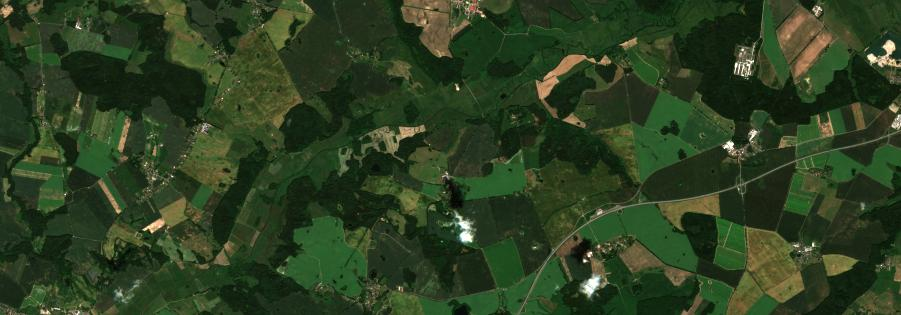

In [3]:
# Get a subset coverage by slicing on time, trimming on space, encoded in JPEG.

from IPython.display import Image
import requests

# Set base url which can be used in further code examples
service_endpoint = "https://mundi.rasdaman.com/rasdaman/ows"
base_wcs_url = service_endpoint + "?service=WCS&version=2.0.1"

request = "&REQUEST=GetCoverage"
cov_id = "&COVERAGEID=S2_L2A_32633_TCI_20m"
subset_time = "&SUBSET=ansi(\"2019-06-16\")"
subset_e = "&SUBSET=E(332796,350817)"
subset_n = "&SUBSET=N(5990042,5996342)"
encode_format = "&FORMAT=image/jpeg"

response = requests.get(base_wcs_url + request + cov_id + subset_time + subset_e + subset_n + encode_format)

# Display result
Image(data=response.content)

...and that's it! It is the functionality of WCS Core only, though; much more is available with the WCS extensions, including band/variable extraction, reprojection, scaling, interpolation, data maintenance, etc. - best check out the [EarthServer webinar series](http://www.earthserver.eu/webinars) for details. In the next section we pick one particular WCS extension, *WCS Processing*, which offers the WCPS datacube analytics language.

## OGC (Web Coverage Processing Service) WCPS

OGC WCPS is a high-level language for spatio-temporal extraction, analysis, filtering, and fusion of coverages. The *return* clause contains the processing and encoding directives. In the for part the coverages addressed are listed; they can be processed in sequence or in combination, enabling data fusion. An optional where clause can be used for server-side filtering - only the coverages matching will be processed and delivered; such results can be both coverages again, or scalars in case of aggregation. Both data and metadata of a coverage are amenable to retrieval. More on the WCPS language can be found in [this tutorial](http://tutorial.rasdaman.org/rasdaman-and-ogc-ws-tutorial/#ogc-web-services-web-coverage-processing-service) and the [EarthServer webinar series](http://www.earthserver.eu/webinars).

Technically, a WCPS request is sent by appending a query to the request:

https://mundi.rasdaman.com/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=...

The following query is equivalent to the previous WCS request which selects a 2D subset from a 3D coverage, and encodes the result as a PNG image; note that "ansi" stands for an ANSI-compliant time axis:

```
for $c in (S2_L2A_32633_TCI_20m)
return 
  encode(
      $c[ E( 332796 : 350817 ), 
          N( 5990042 : 5996342 ), 
          ansi( "2019-06-16" ) ], 
      "image/png" )
```

Let us inspect the query components step-by-step:

* `$c` - the coverage variable, an alias for the coverages in the coverage list (in our case `S2_L2A_32633_TCI_20m`)

* `return` - contains the processing expression, which here returns an encoded coverage

* `encode` - a function which takes a coverage expression and encodes it in the desired format, here PNG

* `$c[ ... ]` - this is a coverage subsetting expression where upper and lower limits are specified to restrict the extents along each axis as needed. In this case, the time axis is trimmed away while E and N are just trimmed, so the result will retain axes E and N.

PS: Before sending such a query we must keep in mind that several characters need to be "escaped" in a GET request, i.e.: they must be replaced by their hexadecimal code. Manually this is tedious, but fortunately there are tools doing this of us, like https://meyerweb.com/eric/tools/dencoder/. The outcome looks less legible to us humans, but as queries are typically generated by JavaScript hits will not become visible to humans anyway:

<a href="https://mundi.rasdaman.com/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for%20%24c%20in%20(S2_L2A_32633_TCI_20m)%0Areturn%20%0A%20%20encode(%0A%20%20%20%20%20%20%24c%5B%20E(%20332796%20%3A%20350817%20)%2C%20%0A%20%20%20%20%20%20%20%20%20%20N(%205990042%20%3A%205996342%20)%2C%20%0A%20%20%20%20%20%20%20%20%20%20ansi(%20%222019-06-16%22%20)%20%5D%2C%20%0A%20%20%20%20%20%20%22image%2Fpng%22%20)">HTTP GET Link</a>

### Temporal Change Analysis with WCPS

Our next query performs time-series processing by calculating, in the Sentinel-2 datacube, the difference between two timeslices of the B04 band. The result is numerically adjusted so that it fits into the range of [0, 255] for encoding in JPEG.

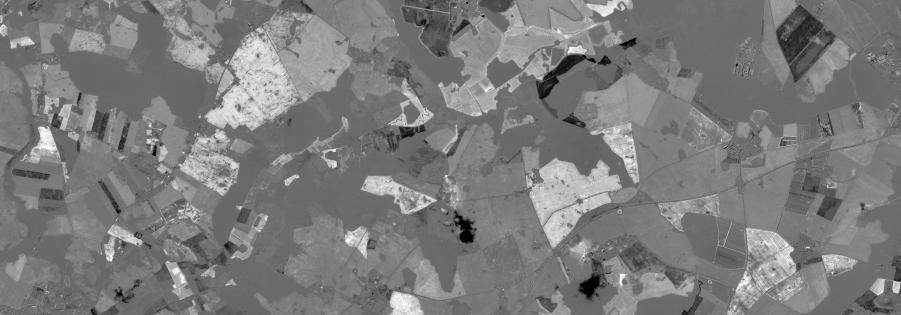

In [2]:
query = '''
for $c in (S2_L2A_32633_B04_20m) 
return
  encode(
    ( 0.20 * ( 1050.0 + ( 
                (float) $c[ ansi( "2019-06-26" ) ] - 
                        $c[ ansi( "2019-06-16" ) ] ) 
            ) 
    )[ E( 332796 : 350817 ), N( 5990042 : 5996342 ) ] / 2
   , "image/jpeg")
'''

# Send a WCPS query for evaluation on the rasdaman server; as WCPS queries usually contain 
# special characters like '[', ']', '{', '}', it is necessary to send POST requests. 
response = requests.post(service_endpoint, data = {'query': query})

# Display result directly
#print response.content
Image(data=response.content)

### Band Math in WCPS

Any sort of pixel-level operation can be written in a simple way in WCPS. We inspect this by calculating the NDVI (Normalized Difference Vegetation Index) on our datacube. To this end, we first change the area of interest to some part of Bremen, Germany, which has both urban and agricultural areas; the cutout we scale to a horizontal size of 700.

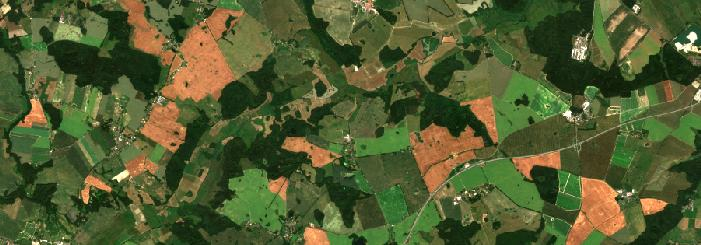

In [3]:
query = '''
for $c in (S2_L2A_32633_TCI_20m)
return 
  encode(
      scale(
        $c[ ansi( "2019-06-26" ), E( 332796 : 350817 ), N( 5990042 : 5996342 ) ] * 1.3,
        { E:"CRS:1"(0:700) }
      ),
      "image/jpeg" )
'''
response = requests.post(service_endpoint, data = {'query': query})
Image(data=response.content)

The NDVI now can be derived easily from the B8 (near-infrared) and B4 (red) bands of the 10m coverage. We provide the well-known formula and additionall threshold the result to show index values greater than 0.5 (higher vegetation) as white while everything else is black. Note that we need to be careful about data types and manually cast to float - the result is supposed to be integer whereas intermediate computation requires float.

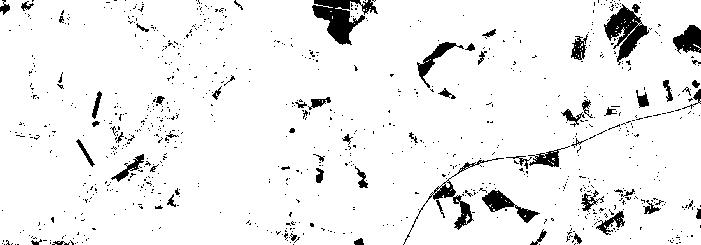

In [6]:
query = '''
for $c in (S2_L2A_32633_B08_10m),
    $d in (S2_L2A_32633_B04_10m) 
let $cutout := [ ansi( "2019-06-16" ), E( 332796 : 350817 ), N( 5990042 : 5996342 ) ]
return
  encode(
         scale(
           (
              ( (($c - $d) / ($c + $d))[ $cutout ]) > 0.5 ) * 255,
              { E:"CRS:1"(0:700) }
           ),
        "image/jpeg"
        )
'''
response = requests.post(service_endpoint, data = {'query': query})
Image(data=response.content)

A false-color composite can be created from the corresponding bands in a straightforward manner by just specifying them in the desired order:

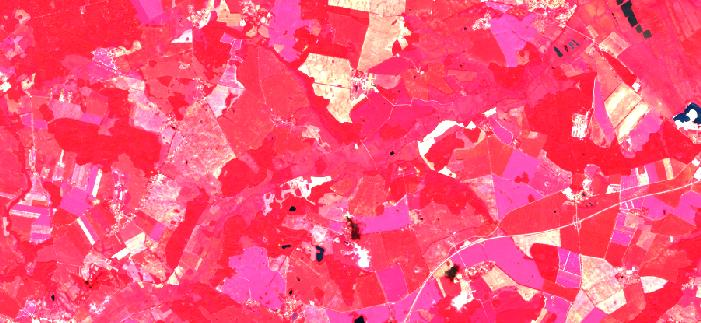

In [5]:
query = '''
for $c in (S2_L2A_32633_B06_20m), 
    $d in (S2_L2A_32633_B04_20m),
    $e in (S2_L2A_32633_B03_20m) 

let $cutout := [ansi("2019-06-16"), E(332796:350817), N(5990042:5998342)]

return
  encode(
    scale(
      {
         red:   $c[ $cutout ] / 5.0;
         green: $d[ $cutout ] / 5.0;
         blue:  $e[ $cutout ] / 5.0
      },
      { E:"CRS:1"(0:700) }
    ) 
  , "image/jpeg")
'''
response = requests.post(service_endpoint, data = {'query': query})
Image(data=response.content)

What if the bands we want to combine come from coverages with different resolutions? We can scale the bands to a common resolution before the operations, e.g. below we combine B12 from a 20m coverage, and B8 / B3 from a higher resolution 10m coverage.

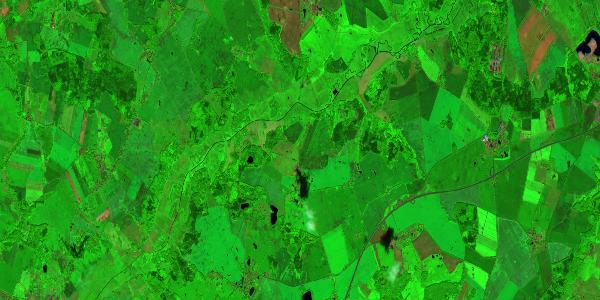

In [7]:
query = '''
for $c in (S2_L2A_32633_B12_20m), 
    $d in (S2_L2A_32633_B08_10m),
    $e in (S2_L2A_32633_B03_10m)

let $cutout := [ ansi( "2019-06-16" ), E( 332796 : 350817 ), N( 5990042 : 5996342 ) ]
    
return
  encode(
    {
      red:   scale( $c  [ $cutout ], { E:"CRS:1"(0:599), N:"CRS:1"(0:299) } );
      green: scale( $d  [ $cutout ], { E:"CRS:1"(0:599), N:"CRS:1"(0:299) } );
      blue:  scale( $e  [ $cutout ], { E:"CRS:1"(0:599), N:"CRS:1"(0:299) } )
    }  
    / 25
  , "image/jpeg")
'''
response = requests.post(service_endpoint, data = {'query': query})
Image(data=response.content)

### Timeseries Aggregation with WCPS

Datacube aggregation is straightforward: select the desired subset and apply an aggregation function such as min, max, avg, count, etc. For example, to calculate the average NDVI value (same spatio-temporal subset as before) the following query can be utilized:

In [12]:
query = '''
for $c in (S2_L2A_32633_B08_10m),
    $d in (S2_L2A_32633_B04_10m)
    
return
  avg(
    (((float) $c - $d) / ((float) $c + $d))
    [ ansi( "2019-06-16" ), E( 332796 : 350817 ), N( 5990042 : 5996342 ) ]
  )
'''
response = requests.post(service_endpoint, data = {'query': query})
print("Average NDVI value: " + response.content)

Average NDVI value: 0.7817173796326267


Finally, one can convert result from rasdaman as Numpy array and do futher processing with other Python libraries.
The below example creates a diagram from 1D JSON array and draw as a plot chart by `matplotlib` library.

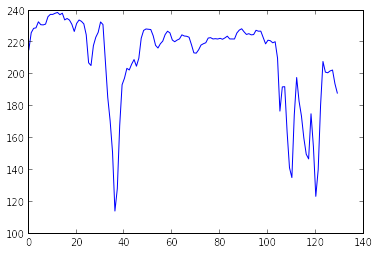

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pp

query = '''
for $c in (S2_L2A_32633_B08_10m),
    $d in (S2_L2A_32633_B04_10m) 
return
  encode(

      (((float) $c - $d) / ((float) $c + $d))
      [ ansi( "2019-06-16" ), E( 332796 ), N( 5990042 : 5991342 ) ] * 255

      , "csv")
'''

response = requests.post(service_endpoint, data = {'query': query})

array = np.array(eval(response.text))
pp.plot(array[np.where(array > 0.0)])
pp.show()